# Building Machine Learning Classifiers: Model selection

### Read in & clean text

In [166]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import random
random.seed(47)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Split into train/test

In [167]:
from sklearn.model_selection import train_test_split
random.seed(47)

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Vectorize text

In [168]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Convert label ham to 0 and spam to 1
labels_num = {'ham': 0, 'spam': 1}
y_train = y_train.map(labels_num)
y_test = y_test.map(labels_num)

# Subset data
X_train_vect = X_train_vect.iloc[1:200,0:25]
X_test_vect = X_test_vect.iloc[1:200,0:25]
y_train = y_train[1:200]
y_test = y_test[1:200]
print(y_train)

print(X_train_vect.shape)
print(y_train)
X_train_vect.head()

1915    0
3790    0
5158    0
5096    0
4454    0
       ..
3423    0
2249    0
1555    0
3446    0
991     0
Name: label, Length: 199, dtype: int64
(199, 25)
1915    0
3790    0
5158    0
5096    0
4454    0
       ..
3423    0
2249    0
1555    0
3446    0
991     0
Name: label, Length: 199, dtype: int64


,body_len,punct%,0,1,2,3,4,5,6,7,...,13,14,15,16,17,18,19,20,21,22
1,121,5.8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62,17.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32,6.2,0.220601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,72,13.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
X_train_vect.to_csv('train_features.csv', index=False)
X_test_vect.to_csv('test_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

### Final evaluation of models

In [170]:
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')
tr_features.head()
print(tr_labels.head())


   label
0      0
1      0
2      0
3      0
4      0


In [171]:
print(tr_labels.label.value_counts())
weights = {0:0.5, 1:0.5}

0    177
1     22
Name: label, dtype: int64


## Logistic Regression Model

### Load model

In [172]:
from sklearn.linear_model import LogisticRegression

LogisticRegression()

#dir(LogisticRegression)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [174]:
lr = LogisticRegression(max_iter=2000, class_weight=weights)
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv = GridSearchCV(lr, parameters, cv=10, n_jobs=-1)
random.seed(47)
%timeit cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

209 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
BEST PARAMS: {'C': 0.001}

0.859 (+/-0.074) for {'C': 0.001}
0.859 (+/-0.074) for {'C': 0.01}
0.859 (+/-0.074) for {'C': 0.1}
0.859 (+/-0.074) for {'C': 1}
0.859 (+/-0.074) for {'C': 10}
0.859 (+/-0.074) for {'C': 100}
0.859 (+/-0.074) for {'C': 1000}


In [175]:
cv.best_estimator_

LogisticRegression(C=0.001, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [176]:
joblib.dump(cv.best_estimator_, 'LR_model.pkl')

['LR_model.pkl']

## Elastic Net Model

### Load model

In [177]:
from sklearn.linear_model import SGDClassifier

SGDClassifier()

#dir(LogisticRegression)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [178]:
import random
import numpy as np
10**np.arange(-3,3, 0.06)

array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03, 7.94328235e-03,
       9.12010839e-03, 1.04712855e-02, 1.20226443e-02, 1.38038426e-02,
       1.58489319e-02, 1.81970086e-02, 2.08929613e-02, 2.39883292e-02,
       2.75422870e-02, 3.16227766e-02, 3.63078055e-02, 4.16869383e-02,
       4.78630092e-02, 5.49540874e-02, 6.30957344e-02, 7.24435960e-02,
       8.31763771e-02, 9.54992586e-02, 1.09647820e-01, 1.25892541e-01,
       1.44543977e-01, 1.65958691e-01, 1.90546072e-01, 2.18776162e-01,
       2.51188643e-01, 2.88403150e-01, 3.31131121e-01, 3.80189396e-01,
       4.36515832e-01, 5.01187234e-01, 5.75439937e-01, 6.60693448e-01,
       7.58577575e-01, 8.70963590e-01, 1.00000000e+00, 1.14815362e+00,
       1.31825674e+00, 1.51356125e+00, 1.73780083e+00, 1.99526231e+00,
      

In [179]:
en = SGDClassifier(max_iter=10000, penalty='elasticnet', loss='log', class_weight=weights)
random.seed(47)
parameters = {
    #'alpha': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1],
    'alpha': 10**np.arange(-3,3, 0.06),
    'l1_ratio' : np.arange(0,1,0.05)
}

cv = GridSearchCV(en, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'alpha': 0.28840315031266206, 'l1_ratio': 0.1}

0.794 (+/-0.245) for {'alpha': 0.001, 'l1_ratio': 0.0}
0.719 (+/-0.434) for {'alpha': 0.001, 'l1_ratio': 0.05}
0.799 (+/-0.266) for {'alpha': 0.001, 'l1_ratio': 0.1}
0.839 (+/-0.191) for {'alpha': 0.001, 'l1_ratio': 0.15000000000000002}
0.779 (+/-0.202) for {'alpha': 0.001, 'l1_ratio': 0.2}
0.819 (+/-0.183) for {'alpha': 0.001, 'l1_ratio': 0.25}
0.824 (+/-0.275) for {'alpha': 0.001, 'l1_ratio': 0.30000000000000004}
0.794 (+/-0.268) for {'alpha': 0.001, 'l1_ratio': 0.35000000000000003}
0.823 (+/-0.157) for {'alpha': 0.001, 'l1_ratio': 0.4}
0.694 (+/-0.353) for {'alpha': 0.001, 'l1_ratio': 0.45}
0.854 (+/-0.132) for {'alpha': 0.001, 'l1_ratio': 0.5}
0.869 (+/-0.069) for {'alpha': 0.001, 'l1_ratio': 0.55}
0.864 (+/-0.076) for {'alpha': 0.001, 'l1_ratio': 0.6000000000000001}
0.829 (+/-0.115) for {'alpha': 0.001, 'l1_ratio': 0.65}
0.784 (+/-0.215) for {'alpha': 0.001, 'l1_ratio': 0.7000000000000001}
0.794 (+/-0.233) for {'alpha':

In [180]:
cv.best_estimator_

SGDClassifier(alpha=0.28840315031266206, average=False,
              class_weight={0: 0.5, 1: 0.5}, early_stopping=False, epsilon=0.1,
              eta0=0.0, fit_intercept=True, l1_ratio=0.1,
              learning_rate='optimal', loss='log', max_iter=10000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [181]:
joblib.dump(cv.best_estimator_, 'EN_model.pkl')

['EN_model.pkl']

## Support Vector Machines

### Load model

In [182]:
from sklearn.svm import SVC

SVC()

dir(SVC)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_estimator_type',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_more_tags',
 '_pairwise',
 '_predict_log_proba',
 '_predict_proba',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predict',
 '_sparse_predict_proba',
 '_validate_for_predict',
 '_validate_targets',
 '_warn_from_fit_status',
 'coef_',
 'decision_function',
 'fit',
 'get_params',
 'n_support_',
 'pr

In [183]:
#weights = {0:0.25, 1:0.75}
svc = SVC(probability=True, gamma='scale', class_weight=weights)
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,5,10,20,50,100]
}

cv = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'C': 100, 'kernel': 'rbf'}

0.889 (+/-0.024) for {'C': 0.01, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.01, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 0.05, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.05, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 0.1, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.1, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 0.25, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.25, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 0.5, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.5, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 0.75, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 0.75, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 1, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 1, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 1.25, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 1.25, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 1.5, 'kernel': 'linear'}
0.889 (+/-0.024) for {'C': 1.5, 'kernel': 'rbf'}
0.889 (+/-0.024) for {'C': 1.75, 'kernel': 

In [184]:
cv.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight={0: 0.5, 1: 0.5},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [185]:
joblib.dump(cv.best_estimator_, 'SVM_model.pkl')

['SVM_model.pkl']

## Multilayer Perceptron Model

### Load model

In [186]:
from sklearn.neural_network import MLPRegressor, MLPClassifier

print(MLPRegressor())
print(MLPClassifier())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, ver

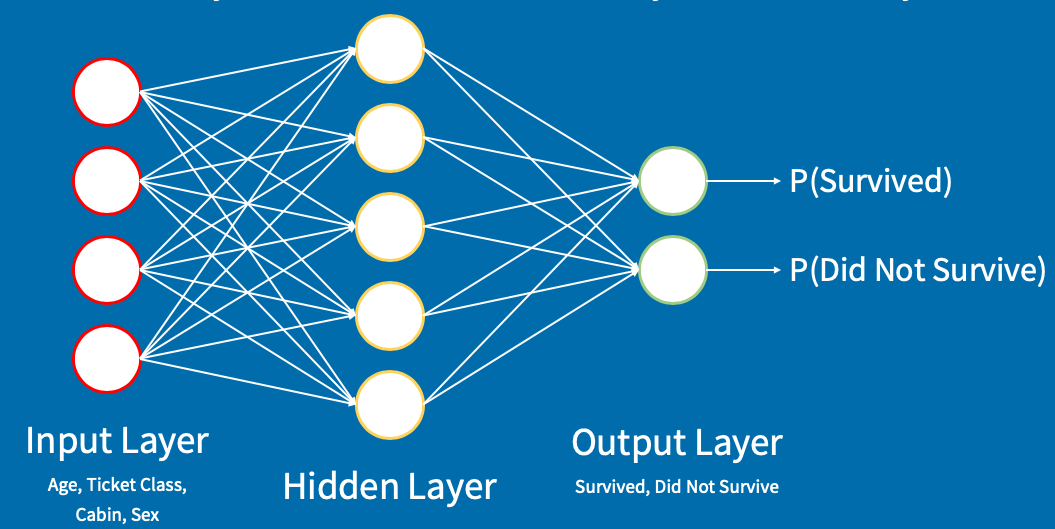

In [187]:
mlp = MLPClassifier(max_iter=5000)
parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

cv = GridSearchCV(mlp, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}

0.865 (+/-0.066) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.864 (+/-0.054) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.884 (+/-0.023) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.88 (+/-0.065) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.88 (+/-0.065) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.885 (+/-0.05) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.879 (+/-0.058) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.874 (+/-0.044) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.9 (+/-0.054) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_r

In [188]:
cv.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=5000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [189]:
joblib.dump(cv.best_estimator_, 'MLP_model.pkl')

['MLP_model.pkl']

## Random Forest

### Load model

In [190]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

print(RandomForestClassifier())
print(RandomForestRegressor())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      rand

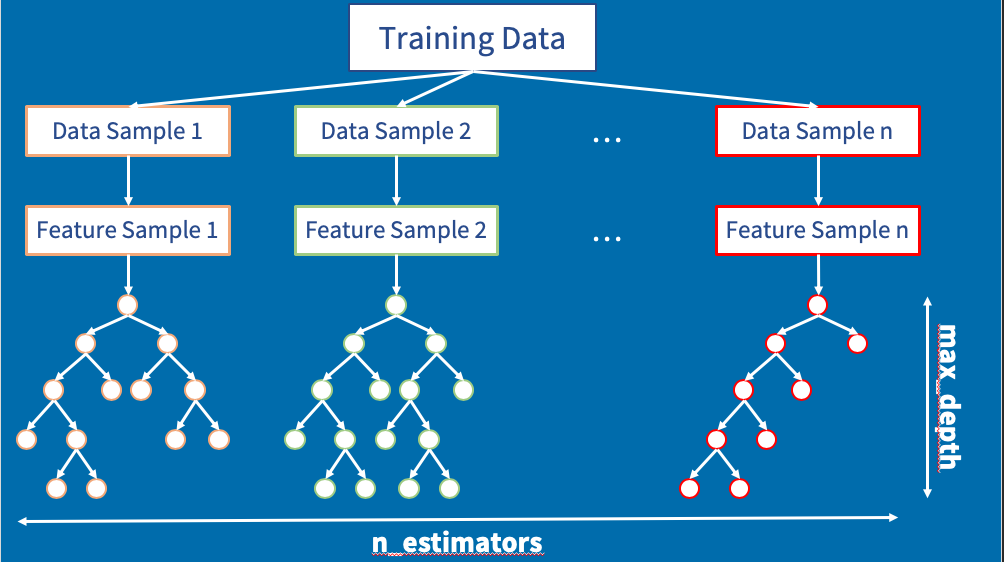

In [191]:
rf = RandomForestClassifier(class_weight=weights)
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 50}

0.879 (+/-0.058) for {'max_depth': 2, 'n_estimators': 5}
0.894 (+/-0.02) for {'max_depth': 2, 'n_estimators': 50}
0.889 (+/-0.024) for {'max_depth': 2, 'n_estimators': 250}
0.884 (+/-0.074) for {'max_depth': 4, 'n_estimators': 5}
0.904 (+/-0.097) for {'max_depth': 4, 'n_estimators': 50}
0.909 (+/-0.082) for {'max_depth': 4, 'n_estimators': 250}
0.904 (+/-0.059) for {'max_depth': 8, 'n_estimators': 5}
0.899 (+/-0.095) for {'max_depth': 8, 'n_estimators': 50}
0.914 (+/-0.082) for {'max_depth': 8, 'n_estimators': 250}
0.884 (+/-0.068) for {'max_depth': 16, 'n_estimators': 5}
0.919 (+/-0.087) for {'max_depth': 16, 'n_estimators': 50}
0.904 (+/-0.097) for {'max_depth': 16, 'n_estimators': 250}
0.874 (+/-0.085) for {'max_depth': 32, 'n_estimators': 5}
0.909 (+/-0.082) for {'max_depth': 32, 'n_estimators': 50}
0.904 (+/-0.097) for {'max_depth': 32, 'n_estimators': 250}
0.904 (+/-0.049) for {'max_depth': None, 'n_estimators': 5}
0.914 (+/-0.0

In [192]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5, 1: 0.5}, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [193]:
joblib.dump(cv.best_estimator_, 'RF_model.pkl')

['RF_model.pkl']

## Gradient Boosting Algorithm

### Load model

In [194]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

print(GradientBoostingClassifier())
print(GradientBoostingRegressor())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
 

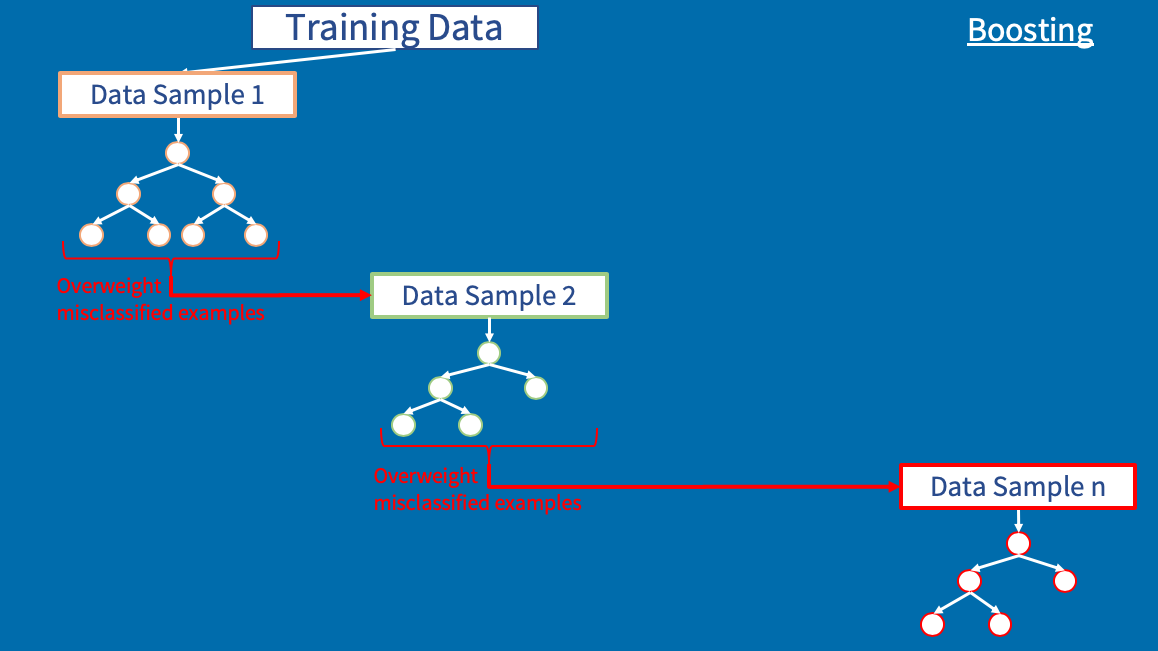

In [195]:
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

cv = GridSearchCV(gb, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}

0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.894 (+/-0.02) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.909 (+/-0.041) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.884 (+/-0.103) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.889 (+/-0.103) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.889 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.879 (+/-0.111) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.874 (+/-0.114) for {'learning_r

In [196]:
cv.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [197]:
joblib.dump(cv.best_estimator_, 'GB_model.pkl')

['GB_model.pkl']

## KNN Model

### Load model

In [198]:
from sklearn.neighbors import KNeighborsClassifier

print(KNeighborsClassifier())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [199]:
knn = KNeighborsClassifier()
parameters = {
    'n_neighbors' : range(1, 40),
    'weights' : ['uniform', 'distance'],
    'n_jobs' : [-1]
}

cv = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
random.seed(47)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'n_jobs': -1, 'n_neighbors': 3, 'weights': 'uniform'}

0.884 (+/-0.117) for {'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}
0.884 (+/-0.117) for {'n_jobs': -1, 'n_neighbors': 1, 'weights': 'distance'}
0.914 (+/-0.081) for {'n_jobs': -1, 'n_neighbors': 2, 'weights': 'uniform'}
0.884 (+/-0.117) for {'n_jobs': -1, 'n_neighbors': 2, 'weights': 'distance'}
0.929 (+/-0.081) for {'n_jobs': -1, 'n_neighbors': 3, 'weights': 'uniform'}
0.909 (+/-0.089) for {'n_jobs': -1, 'n_neighbors': 3, 'weights': 'distance'}
0.919 (+/-0.083) for {'n_jobs': -1, 'n_neighbors': 4, 'weights': 'uniform'}
0.914 (+/-0.105) for {'n_jobs': -1, 'n_neighbors': 4, 'weights': 'distance'}
0.914 (+/-0.103) for {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.899 (+/-0.104) for {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.914 (+/-0.103) for {'n_jobs': -1, 'n_neighbors': 6, 'weights': 'uniform'}
0.899 (+/-0.104) for {'n_jobs': -1, 'n_neighbors': 6, 'weights': 'distance'}
0.914 (+/-0.1

In [200]:
cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [201]:
joblib.dump(cv.best_estimator_, 'KNN_model.pkl')

['KNN_model.pkl']

### Load model

In [202]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

print(GradientBoostingClassifier())
print(GradientBoostingRegressor())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
 

## Validation

### Read data

In [203]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

te_features = pd.read_csv('test_features.csv')
te_labels = pd.read_csv('test_labels.csv')

In [204]:
models = {}

for mdl in ['LR', 'SVM', 'RF', 'GB', 'EN', 'KNN', 'MLP']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))

In [205]:
models

{'LR': LogisticRegression(C=0.001, class_weight={0: 0.5, 1: 0.5}, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'SVM': SVC(C=100, break_ties=False, cache_size=200, class_weight={0: 0.5, 1: 0.5},
     coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
     kernel='rbf', max_iter=-1, probability=True, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                        class_weight={0: 0.5, 1: 0.5}, criterion='gini',
                        max_depth=16, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                      

In [206]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [207]:
for name, mdl in models.items():
    evaluate_model(name, mdl, te_features, te_labels)

LR -- Accuracy: 0.849 / Precision: 0.0 / Recall: 0.0 / Latency: 0.9ms
SVM -- Accuracy: 0.899 / Precision: 0.696 / Recall: 0.552 / Latency: 1.3ms
RF -- Accuracy: 0.884 / Precision: 0.6 / Recall: 0.621 / Latency: 5.8ms
GB -- Accuracy: 0.889 / Precision: 0.706 / Recall: 0.414 / Latency: 1.5ms
EN -- Accuracy: 0.854 / Precision: 0.0 / Recall: 0.0 / Latency: 0.6ms
KNN -- Accuracy: 0.889 / Precision: 0.6 / Recall: 0.724 / Latency: 121.9ms
MLP -- Accuracy: 0.874 / Precision: 0.833 / Recall: 0.172 / Latency: 1.7ms


/home/sanju/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
evaluate_model('Random Forest', models['RF'], te_features, te_labels)

Random Forest -- Accuracy: 0.884 / Precision: 0.6 / Recall: 0.621 / Latency: 7.8ms


In [209]:
y_pred = models['SVM'].predict(te_features)

In [210]:
from sklearn.metrics import confusion_matrix
confusion_matrix(te_labels, y_pred)

array([[163,   7],
       [ 13,  16]])

In [211]:
from sklearn.metrics import roc_curve
roc_curve(te_labels, y_pred)

(array([0.        , 0.04117647, 1.        ]),
 array([0.        , 0.55172414, 1.        ]),
 array([2, 1, 0]))

In [212]:
from sklearn.metrics import roc_auc_score
# calculate AUC
auc = roc_auc_score(te_labels, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.755


No Skill: ROC AUC=0.500
Model: ROC AUC=0.854


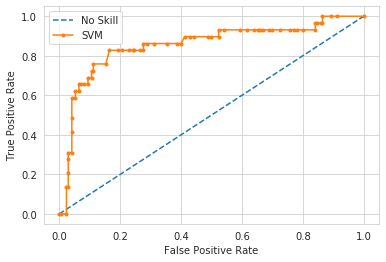

In [213]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(te_labels))]
ns_probs
lr_probs = models['SVM'].predict_proba(te_features)
lr_probs
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs
# calculate scores
ns_auc = roc_auc_score(te_labels, ns_probs)
lr_auc = roc_auc_score(te_labels, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(te_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(te_labels, lr_probs)
ns_fpr
lr_fpr
# plot the roc curve for the model
from matplotlib import pyplot 
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

SVM: f1=0.615 auc=0.488


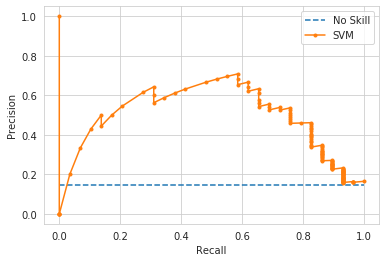

In [214]:
# Predict Probabilities
lr_probs = models['SVM'].predict_proba(te_features)
lr_probs
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs
# predict class values
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
yhat = models['SVM'].predict(te_features)
lr_precision, lr_recall, _ = precision_recall_curve(te_labels, lr_probs)
lr_f1, lr_auc = f1_score(te_labels, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('SVM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
#no_skill = len(te_labels[te_labels==1]) / len(te_labels)
no_skill = (te_labels[te_labels==1].count()) / (te_labels.count())
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

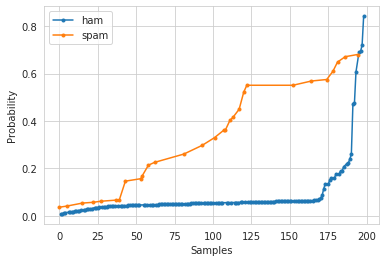

In [215]:
#pyplot.plot([0, 125], [sorted(lr_probs[np.where(te_labels ==0)[0]])], linestyle='--', label='No Skill')
pyplot.plot(np.where(te_labels ==0)[0], sorted(lr_probs[np.where(te_labels ==0)[0]]), marker='.', label='ham')
pyplot.plot(np.where(te_labels ==1)[0], sorted(lr_probs[np.where(te_labels ==1)[0]]), marker='.', label='spam')
# axis labels
pyplot.xlabel('Samples')
pyplot.ylabel('Probability')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [216]:
import pandas as pd

probs = {'labels': te_labels['label'][0:len(te_labels)].tolist(),
        'prob': lr_probs.tolist(),
         'sample' : range(1,len(te_labels)+1)
        }
df = pd.DataFrame(probs, columns = ['labels', 'prob', 'sample'])
df = df.sort_values(by=['prob'])
df['sample'] =range(1,len(te_labels)+1)
df.head()

,labels,prob,sample
69,0,0.007469,1
68,0,0.008460,2
185,0,0.010806,3
86,0,0.012760,4
89,0,0.014434,5


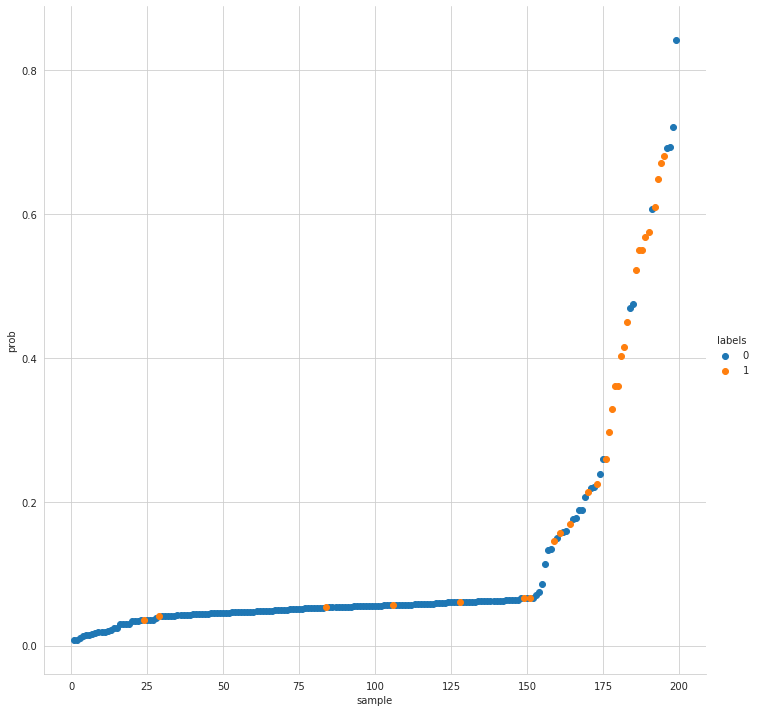

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.FacetGrid(df, hue="labels", height=10) \
   .map(plt.scatter, 'sample', "prob") \
   .add_legend()
plt.show()